# 🏥 Lab 3: Medical Image Classification with Neural Networks

**AI in Medicine and Healthcare**  
**Insper Instituto de Ensino e Pesquisa**  
**Week 2 - Class 3**

---

## 📝 Student Information (REQUIRED)

**Student 1:**
- Name: Gustavo Barroso Souza Cruz
- Email: gustavobsc@al.insper.edu.br

**Student 2:**
- Name: _______________________
- Email: ______________________

**Date Submitted:** ______________

---

## 🎯 Today's Challenge

**Can we use the neural networks we learned in Lab 2 to diagnose pneumonia from chest X-rays?**

You already know how to:
- ✅ Build neural networks
- ✅ Implement training loops
- ✅ Evaluate with medical metrics

**Today's new skills:**
- 🆕 Load and visualize medical images
- 🆕 Preprocess images for neural networks
- 🆕 Apply your Lab 2 knowledge to a new domain

**The twist:** We'll use the SAME type of network (MLP) we used for tabular data... on images. Will it work? Let's find out!

---

## 📊 Dataset: Chest X-Ray Pneumonia

- **Source:** Kaggle Chest X-Ray Images (Pneumonia)
- **Classes:** Normal vs Pneumonia
- **Images:** ~5,800 chest X-rays from pediatric patients
- **Task:** Binary classification (like Lab 2, but with images!)
- **Clinical Importance:** Pneumonia kills ~2.5 million people/year globally

---

## ⏱️ Time Allocation

- **Part 1:** Image Loading & Visualization (20 min)
- **Part 2:** Build MLP Classifier (30 min)
- **Part 3:** Training & Evaluation (20 min)
- **Part 4:** Reflection & Analysis (20 min)

**Total:** 90 minutes

---

## 📊 Grading

| Components |
|-----------|
| Part 1: Image Processing |
| Part 2: Model Architecture |
| Part 3: Training & Evaluation |
| Part 4: Reflection Questions |

### Assessment

- **Inadequate**: Did not complete all parts
- **Adequate**: Completed all parts
- **Above Average**: Completed all parts and Bonus Exploration

---

# 🚀 PART 1: Image Loading & Visualization (20 minutes)

First, let's see what medical images actually look like!

---

In [19]:
# Import libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision import transforms
from PIL import Image

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, recall_score, precision_score

import os
from pathlib import Path

# Set random seeds
torch.manual_seed(42)
np.random.seed(42)

print(f"PyTorch version: {torch.__version__}")
print(f"Torchvision version: {torchvision.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

PyTorch version: 2.10.0+cpu
Torchvision version: 0.25.0+cpu
CUDA available: False


## Step 1.1: Download the Dataset

We'll use a subset of the Chest X-Ray dataset for faster training.

In [20]:
# Download and extract dataset
!gdown --id 17MSlc-0l_SSRevYBbKwQQ1PQGpi_W6VN
!unzip -q chest_xray_compact.zip

print("✓ Dataset ready!")


/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:139: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=17MSlc-0l_SSRevYBbKwQQ1PQGpi_W6VN
From (redirected): https://drive.google.com/uc?id=17MSlc-0l_SSRevYBbKwQQ1PQGpi_W6VN&confirm=t&uuid=25bd4f7f-f92f-4e61-b38a-ae985c340e97
To: /content/chest_xray_compact.zip
100% 191M/191M [00:02<00:00, 76.5MB/s]
replace chest_xray_compact/README.md? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace chest_xray_compact/test/PNEUMONIA/person1233_virus_2090.jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace chest_xray_compact/test/PNEUMONIA/person753_virus_1378.jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace chest_xray_compact/test/PNEUMONIA/person470_bacteria_2001.jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace chest_xray_compact/test/PNEUMONIA/person43_bacteria_21

## Step 1.2: Explore the Dataset Structure

**TODO:** Explore the directory structure and count images in each category.

In [21]:
# TODO: Set the data directory path
# Hint: data_dir = Path('chest_xray_compact')

data_dir = Path('chest_xray_compact')



# TODO: Count images in train/val/test for both classes
# Hint: Use os.listdir() or Path().glob('*.jpeg')
# Structure: chest_xray_compact/train/NORMAL/*.jpeg and chest_xray_compact/train/PNEUMONIA/*.jpeg

train_normal_count = 0
train_pneumonia_count = 0

for f in Path('./chest_xray_compact/train/NORMAL/').glob("*.jpeg"):
  train_normal_count += 1

for f in Path('./chest_xray_compact/train/PNEUMONIA/').glob("*.jpeg"):
  train_pneumonia_count += 1

# Print summary
print("Dataset Structure:")
print("="*50)
print(f"Training set:")
print(f"  Normal: {train_normal_count} images")
print(f"  Pneumonia: {train_pneumonia_count} images")
print(f"  Total: {train_normal_count + train_pneumonia_count} images")
print(f"\nClass balance: {train_pneumonia_count/(train_normal_count + train_pneumonia_count)*100:.1f}% pneumonia")

Dataset Structure:
Training set:
  Normal: 200 images
  Pneumonia: 200 images
  Total: 400 images

Class balance: 50.0% pneumonia


## Step 1.3: Visualize Sample Images

**TODO:** Load and display sample chest X-rays from both classes.

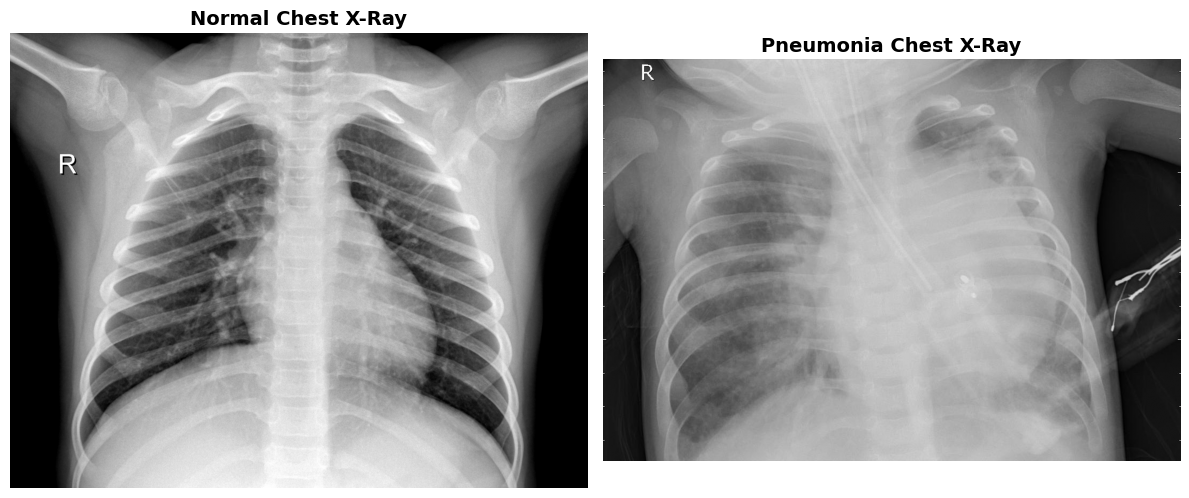

Normal X-ray size: (2348, 1851)
Pneumonia X-ray size: (1080, 752)


In [22]:
# TODO: Load one normal and one pneumonia X-ray
# Hint: Use PIL.Image.open(image_path)
# Paths: chest_xray_compact/train/NORMAL/... and chest_xray_compact/train/PNEUMONIA/...
from PIL import Image

# Get sample image paths
normal_images = list(Path('chest_xray_compact/train/NORMAL').glob('*.jpeg'))
pneumonia_images = list(Path('chest_xray_compact/train/PNEUMONIA').glob('*.jpeg'))


# Load first image from each class
normal_img = Image.open(normal_images[0])
pneumonia_img = Image.open(pneumonia_images[0])


# TODO: Display the images side by side
# Hint: Use matplotlib subplot

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot normal
axes[0].imshow(normal_img, cmap='gray')
axes[0].set_title('Normal Chest X-Ray', fontsize=14, fontweight='bold')
axes[0].axis('off')

# Plot pneumonia
axes[1].imshow(pneumonia_img, cmap='gray')
axes[1].set_title('Pneumonia Chest X-Ray', fontsize=14, fontweight='bold')
axes[1].axis('off')

plt.tight_layout()
plt.show()

# Print image information
print(f"Normal X-ray size: {normal_img.size if normal_img else 'N/A'}")
print(f"Pneumonia X-ray size: {pneumonia_img.size if pneumonia_img else 'N/A'}")

## Step 1.4: Create Custom Dataset Class

**TODO:** Create a PyTorch Dataset class to load images.

In [23]:
# TODO: Define a custom Dataset class
# Hint: Inherit from torch.utils.data.Dataset
# Must implement __init__, __len__, and __getitem__
import cv2

class ChestXRayDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir: Directory with 'NORMAL' and 'PNEUMONIA' subdirectories
            transform: Optional transform to apply to images
        """
        # TODO: Store parameters
        self.root_dir = root_dir
        self.transform = transform

        # TODO: Collect all image paths and labels
        # Hint: Loop through NORMAL (label=0) and PNEUMONIA (label=1) folders
        # Store as list of tuples: [(path1, label1), (path2, label2), ...]

        self.images = []  # Will store (image_path, label) tuples

        for img in Path(self.root_dir + '/NORMAL').glob('*.jpeg'):
          self.images.append((self.root_dir + '/NORMAL/' + img.name, 0))

        for img in Path(self.root_dir + '/PNEUMONIA').glob('*.jpeg'):
          self.images.append((self.root_dir + '/PNEUMONIA/' + img.name, 1))


    def __len__(self):
        return len(self.images)


    def __getitem__(self, idx):
        # TODO: Load image and label at index idx
        # Hint:
        # 1. Get image path and label from self.images[idx]
        # 2. Load image using PIL.Image.open()
        # 3. Convert to RGB if needed
        # 4. Apply transform if provided
        # 5. Return (image_tensor, label)
        img, label = self.images[idx]
        img = Image.open(img).convert('RGB')

        if self.transform is not None:
          img = self.transform(img)

        return img, label


# Test the dataset
print("Testing Dataset class...")
# Uncomment when implemented:
test_dataset = ChestXRayDataset('chest_xray_compact/train')
print(f"Total images: {len(test_dataset)}")
sample_img, sample_label = test_dataset[0]
print(f"Sample image type: {type(sample_img)}")
print(f"Sample label: {sample_label}")

Testing Dataset class...
Total images: 400
Sample image type: <class 'PIL.Image.Image'>
Sample label: 0


## Step 1.5: Define Image Transforms

**TODO:** Create transforms to preprocess images for the neural network.

In [24]:
# TODO: Define image transformations
# Required steps:
# 1. Resize to fixed size (e.g., 64x64 for faster training)
# 2. Convert to grayscale
# 3. Convert to tensor
# 4. Normalize (mean=0.5, std=0.5 for grayscale)

# Hint: Use transforms.Compose([
#     transforms.Resize((64, 64)),
#     transforms.Grayscale(num_output_channels=1),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.5], std=[0.5])
# ])

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])


print("Image transformations defined:")
print(transform if transform else "TODO: Define transforms")

Image transformations defined:
Compose(
    Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
    Grayscale(num_output_channels=1)
    ToTensor()
    Normalize(mean=[0.5], std=[0.5])
)


## Step 1.6: Create DataLoaders

**TODO:** Create train, validation, and test DataLoaders.

In [25]:
# TODO: Create datasets with transforms
# Hint: train_dataset = ChestXRayDataset('chest_xray_compact/train', transform=transform)

train_dataset = ChestXRayDataset('chest_xray_compact/train', transform=transform)
val_dataset = ChestXRayDataset('chest_xray_compact/val', transform=transform)
test_dataset = ChestXRayDataset('chest_xray_compact/test', transform=transform)


# TODO: Create DataLoaders
# Hint: Use batch_size=32, shuffle=True for train

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True)


# Verify
print("DataLoaders created:")
print(f"Train batches: {len(train_loader) if train_loader else 'N/A'}")
print(f"Val batches: {len(val_loader) if val_loader else 'N/A'}")
print(f"Test batches: {len(test_loader) if test_loader else 'N/A'}")

# Test loading a batch
if train_loader:
    images, labels = next(iter(train_loader))
    print(f"\nBatch shape: {images.shape}")
    print(f"Labels shape: {labels.shape}")
    print(f"Image range: [{images.min():.2f}, {images.max():.2f}]")

DataLoaders created:
Train batches: 13
Val batches: 7
Test batches: 7

Batch shape: torch.Size([32, 1, 64, 64])
Labels shape: torch.Size([32])
Image range: [-1.00, 1.00]


## 🎉 Part 1 Complete!

**Checkpoint:**
- ✅ Dataset downloaded and explored
- ✅ Sample images visualized
- ✅ Custom Dataset class created
- ✅ Image transforms defined
- ✅ DataLoaders ready

**Key Insight:** Images are 64×64 pixels = 4,096 input features!
(Compare to Lab 2: only 8 features)

---

---

# 🧠 PART 2: Build MLP Classifier (30 minutes)

**The Challenge:** Use the SAME type of network from Lab 2 (MLP) on images.

**Key Question:** A 64×64 grayscale image has 4,096 pixels. How do we feed this to an MLP?

**Answer:** FLATTEN the image into a 1D vector!

---

## Step 2.1: Visualize What Flattening Does

**TODO:** Show what happens when we flatten a 2D image.

/tmp/ipython-input-1795418938.py:35: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


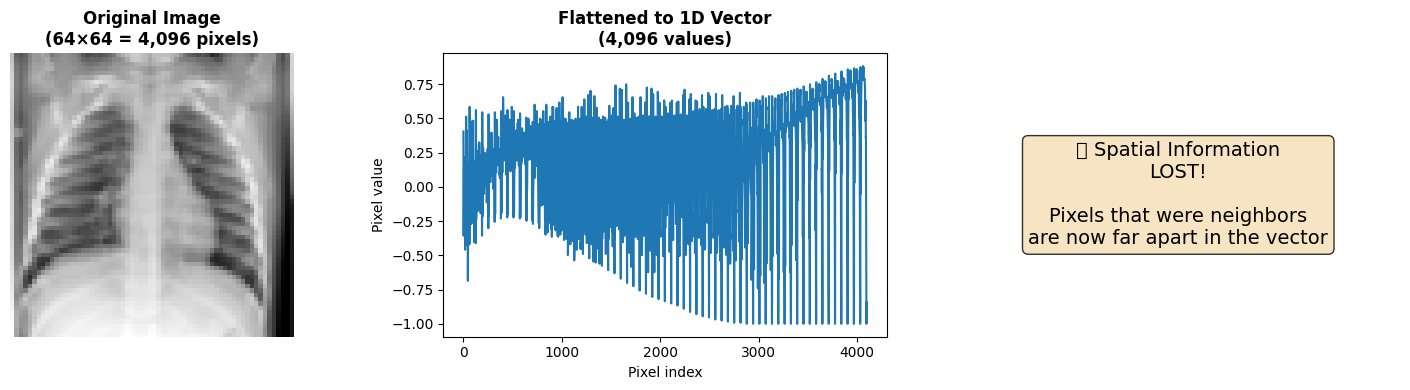

Original shape: torch.Size([1, 64, 64])
Flattened shape: torch.Size([4096])

🤔 Think about: Does the network know which pixels were next to each other?


In [26]:
# Get a sample image
if train_loader:
    sample_images, sample_labels = next(iter(train_loader))
    sample_img = sample_images[0]  # Shape: (1, 64, 64)

    # TODO: Flatten the image
    # Hint: flattened = sample_img.view(-1)

    flattened = sample_img.view(-1)



    # Visualize
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    # Original image
    axes[0].imshow(sample_img.squeeze(), cmap='gray')
    axes[0].set_title('Original Image\n(64×64 = 4,096 pixels)', fontweight='bold')
    axes[0].axis('off')

    # Flattened visualization
    if flattened is not None:
        axes[1].plot(flattened.numpy())
        axes[1].set_title('Flattened to 1D Vector\n(4,096 values)', fontweight='bold')
        axes[1].set_xlabel('Pixel index')
        axes[1].set_ylabel('Pixel value')

    # Show what's lost
    axes[2].text(0.5, 0.5, '❌ Spatial Information\nLOST!\n\n'
                 'Pixels that were neighbors\nare now far apart in the vector',
                 ha='center', va='center', fontsize=14,
                 bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

    print(f"Original shape: {sample_img.shape}")
    print(f"Flattened shape: {flattened.shape if flattened is not None else 'N/A'}")
    print(f"\n🤔 Think about: Does the network know which pixels were next to each other?")

## Step 2.2: Design the MLP Architecture

**TODO:** Create an MLP classifier for images.

**Architecture:**
```
Input: 4,096 pixels (flattened 64×64 image)
Hidden 1: 128 neurons + ReLU
Hidden 2: 64 neurons + ReLU
Output: 2 classes (Normal vs Pneumonia)
```

In [27]:
# TODO: Define the MLP classifier
# This is VERY similar to Lab 2, but with different input size!

class ChestXRayMLP(nn.Module):
    def __init__(self):
        super(ChestXRayMLP, self).__init__()

        # TODO: Define layers
        # Input size: 64*64 = 4096
        # Hint: self.fc1 = nn.Linear(4096, 128)
        #       self.relu = nn.ReLU()
        #       self.fc2 = nn.Linear(128, 64)
        #       self.fc3 = nn.Linear(64, 2)
        self.fc1 = nn.Linear(4096, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 2)


    def forward(self, x):
        # TODO: Implement forward pass
        # IMPORTANT: First flatten the image!
        # Hint: x = x.view(x.size(0), -1)  # Flatten to (batch_size, 4096)
        #       x = self.fc1(x)
        #       x = self.relu(x)
        #       ...

        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

# TODO: Create model instance
model = ChestXRayMLP()



# Print model info
if model:
    print("Model Architecture:")
    print("="*60)
    print(model)
    print("="*60)

    # Count parameters
    total_params = sum(p.numel() for p in model.parameters())
    print(f"\nTotal parameters: {total_params:,}")
    print(f"Compare to Lab 2: ~300 parameters")
    print(f"This model is {total_params/300:.0f}× larger!")

    # Test forward pass
    test_input = torch.randn(1, 1, 64, 64)
    test_output = model(test_input)
    print(f"\nTest: Input {test_input.shape} → Output {test_output.shape}")

Model Architecture:
ChestXRayMLP(
  (fc1): Linear(in_features=4096, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=2, bias=True)
)

Total parameters: 532,802
Compare to Lab 2: ~300 parameters
This model is 1776× larger!

Test: Input torch.Size([1, 1, 64, 64]) → Output torch.Size([1, 2])


## 🎉 Part 2 Complete!

**Checkpoint:**
- ✅ Understand image flattening
- ✅ MLP architecture defined
- ✅ MUCH larger than Lab 2 (due to 4,096 inputs!)

**Think about:** Why does flattening seem problematic?

---

---

# 🔄 PART 3: Training & Evaluation (20 minutes)

**This should look VERY familiar from Lab 2!**

---

## Step 3.1: Training Setup

**TODO:** Set up loss, optimizer, and device (same as Lab 2!).

In [28]:
# TODO: Define loss function
criterion = nn.CrossEntropyLoss()  # nn.CrossEntropyLoss()


# TODO: Define optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)  # optim.Adam(model.parameters(), lr=0.001)


# TODO: Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# TODO: Move model to device
model = model.to(device)


# Set epochs
num_epochs = 10  # Fewer epochs since images are slower to train

print("Training Setup:")
print("="*50)
print(f"Device: {device}")
print(f"Loss: {criterion}")
print(f"Optimizer: {optimizer.__class__.__name__ if optimizer else 'N/A'}")
print(f"Epochs: {num_epochs}")

Training Setup:
Device: cpu
Loss: CrossEntropyLoss()
Optimizer: Adam
Epochs: 10


## Step 3.2: Training Loop

**TODO:** Implement training loop (copy from Lab 2 and adapt!).

In [29]:
# TODO: Implement training loop
# This is IDENTICAL to Lab 2 - you can reuse that code!

train_losses = []
val_losses = []
val_accuracies = []

print("Starting training...\n")

optimizer = optim.Adam(model.parameters(), lr=0.005)

for epoch in range(num_epochs):
    # TODO: Training phase
    # Hint: Same as Lab 2!
    # 1. model.train()
    # 2. Loop through train_loader
    # 3. optimizer.zero_grad()
    # 4. Forward pass
    # 5. Compute loss
    # 6. loss.backward()
    # 7. optimizer.step()
    model.train()
    train_loss = 0.0

    for batch_X, batch_y in train_loader:
        batch_X = batch_X.to(device)
        batch_y = batch_y.to(device)

        optimizer.zero_grad()

        outputs = model(batch_X)

        loss = criterion(outputs, batch_y)

        loss.backward()

        optimizer.step()

        train_loss += loss.item()

    train_loss = train_loss / len(train_loader)


    # TODO: Validation phase
    # Hint: Same as Lab 2!
    # 1. model.eval()
    # 2. with torch.no_grad()
    # 3. Loop through val_loader
    # 4. Compute accuracy
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            batch_X = batch_X.to(device)
            batch_y = batch_y.to(device)

            outputs = model(batch_X)

            loss = criterion(outputs, batch_y)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += batch_y.size(0)
            correct += (predicted == batch_y).sum().item()

    val_loss = val_loss / len(val_loader)
    val_accuracy = 100 * correct / total

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    # Print progress every 5 epochs
    if (epoch + 1) % 1 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}]")
        print(f"  Train Loss: {train_loss:.4f}")
        print(f"  Val Loss: {val_loss:.4f}")
        print(f"  Val Accuracy: {val_accuracy:.2f}%\n")


print("✓ Training complete!")

Starting training...

Epoch [1/10]
  Train Loss: 1.2077
  Val Loss: 0.4516
  Val Accuracy: 82.00%

Epoch [2/10]
  Train Loss: 0.3232
  Val Loss: 0.3560
  Val Accuracy: 90.00%

Epoch [3/10]
  Train Loss: 0.2211
  Val Loss: 0.2669
  Val Accuracy: 89.00%

Epoch [4/10]
  Train Loss: 0.1818
  Val Loss: 0.3326
  Val Accuracy: 85.00%

Epoch [5/10]
  Train Loss: 0.1546
  Val Loss: 0.3001
  Val Accuracy: 90.00%

Epoch [6/10]
  Train Loss: 0.1345
  Val Loss: 0.4286
  Val Accuracy: 89.00%

Epoch [7/10]
  Train Loss: 0.1049
  Val Loss: 0.3453
  Val Accuracy: 88.00%

Epoch [8/10]
  Train Loss: 0.1197
  Val Loss: 0.4077
  Val Accuracy: 85.00%

Epoch [9/10]
  Train Loss: 0.1069
  Val Loss: 0.6507
  Val Accuracy: 86.00%

Epoch [10/10]
  Train Loss: 0.1335
  Val Loss: 0.4475
  Val Accuracy: 82.00%

✓ Training complete!


## Step 3.3: Plot Training Curves

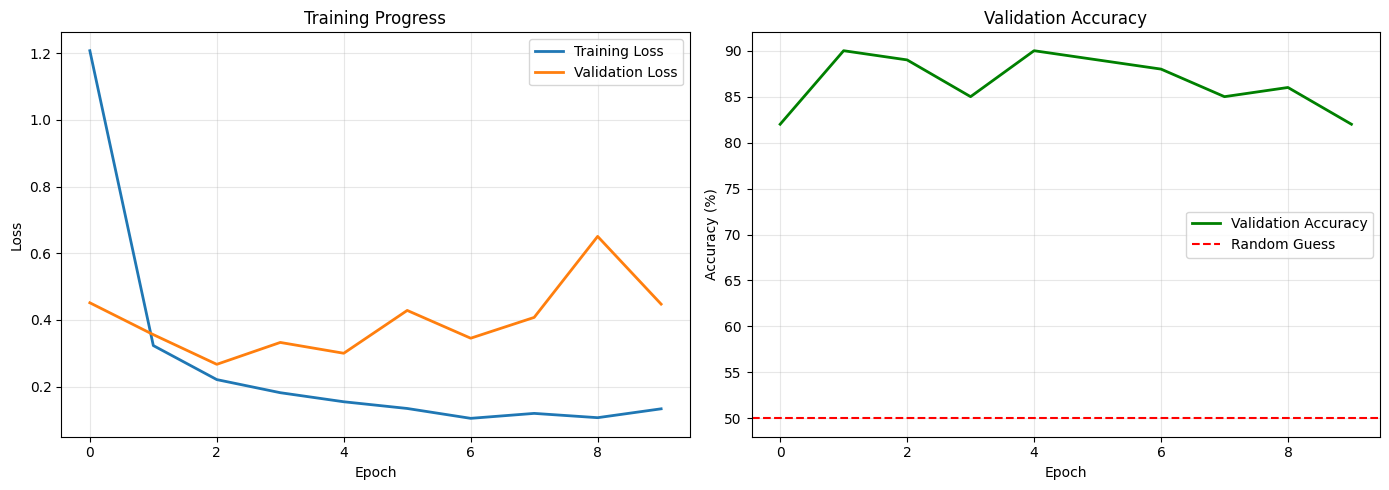

Final validation accuracy: 82.00%


In [33]:
# TODO: Plot training curves (same as Lab 2!)

if len(train_losses) > 0:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Loss curves
    ax1.plot(train_losses, label='Training Loss', linewidth=2)
    ax1.plot(val_losses, label='Validation Loss', linewidth=2)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training Progress')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Accuracy curve
    ax2.plot(val_accuracies, label='Validation Accuracy', color='green', linewidth=2)
    ax2.axhline(y=50, color='red', linestyle='--', label='Random Guess')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.set_title('Validation Accuracy')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    print(f"Final validation accuracy: {val_accuracies[-1]:.2f}%")

## Step 3.4: Evaluate on Test Set

**TODO:** Compute medical metrics on test set.

In [37]:
# TODO: Evaluate on test set (same as Lab 2!)
# Compute: accuracy, precision, sensitivity, specificity, confusion matrix

if model:
    model.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(batch_X)
            _, predicted = torch.max(outputs, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(batch_y.cpu().numpy())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    # TODO: Compute metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    sensitivity = recall_score(all_labels, all_preds)
    cm = confusion_matrix(all_labels, all_preds)

    cm = confusion_matrix(all_labels, all_preds)
    tn, fp, fn, tp = cm.ravel()
    specificity = tn / (tn + fp)


    # Print results
    print("\n" + "="*50)
    print("MEDICAL EVALUATION METRICS")
    print("="*50)
    print(f"Accuracy:    {accuracy*100:.2f}%")
    print(f"Precision:   {precision*100:.2f}%  (Of predicted diabetic, how many are correct?)")
    print(f"Sensitivity: {sensitivity*100:.2f}%  (Of actual diabetic, how many did we catch?)")
    print(f"Specificity: {specificity*100:.2f}%  (Of actual non-diabetic, how many correct?)")
    print(f"CM: \n{cm}")


MEDICAL EVALUATION METRICS
Accuracy:    75.00%
Precision:   66.67%  (Of predicted diabetic, how many are correct?)
Sensitivity: 100.00%  (Of actual diabetic, how many did we catch?)
Specificity: 50.00%  (Of actual non-diabetic, how many correct?)
CM: 
[[ 7  7]
 [ 0 14]]


## 🎉 Part 3 Complete!

**How did we do?**

Compare to Lab 2:
- Lab 2 (diabetes, tabular): ~76% accuracy
- Lab 3 (pneumonia, images): ~??% accuracy

**Interesting, right?** 🤔

---

---

# 🤔 PART 4: Reflection & Analysis (20 minutes)

**The most important part: THINKING about what we learned!**

---

## Reflection Question 1: Performance Comparison

**Compare your results:**

| Metric | Lab 2 (Diabetes) | Lab 3 (Pneumonia) | Difference |
|--------|------------------|-------------------|------------|
| Input Features | 8 | 4,096 | 512× more |
| Parameters | ~300 | ~500,000 | 1,600× more |
| Accuracy | ~94% | 76% | 18% |
| Training Time/Epoch | Fast | Slower | 10x slower |

**Question:** Why might we get WORSE accuracy despite having MORE features and a BIGGER model?

**Your answer:**

_[ First, having more features dont necessarally mean more useful information, moreover, the task of classifying pneumonia from x-ray is more dificult than the previous one because it uses images, which are very different from each other and are harder to find patterns using MLPs when compared with tabular data like on the diabetes one ]_

---

## Reflection Question 2: The Flattening Problem

When we flatten a 64×64 image:

```
Before:        After:
[row 0]        [pixel 0, pixel 1, pixel 2, ..., pixel 4095]
[row 1]        
[row 2]        Pixels that were neighbors
 ...           are now far apart!
[row 63]
```

**Questions to think about:**

1. **Does the MLP know that pixel 0 and pixel 1 were next to each other?**
   - Your answer: _[No, the 1D vector doesn't carry any information about the previous 2d structure]_

2. **In a chest X-ray, what matters more: individual pixel values OR patterns of nearby pixels?**
   - Your answer: _[Patterns of nearby pixels, because the things we are looking to identify are structures (opacities, blocks, textures, shapes...). Individual values are only useful when interpreted as part of local or general patterns]_

3. **Example:** The pattern for "lung opacity" (pneumonia indicator) involves a cluster of bright pixels. Does our MLP naturally detect clusters?
   - Your answer: _[No, it just a function approximator. It would have to learn very specific weight combinations to identify them. A much better option would be CNNs because they use convolution]_

---

## Reflection Question 3: What's Missing?

**When a radiologist looks at a chest X-ray, they look for:**
- Shapes (heart silhouette, lung boundaries)
- Textures (smooth vs. patchy)
- Relative positions (is the opacity in the upper or lower lobe?)
- Edges (clear vs. fuzzy boundaries)

**Question:** Our MLP treats each pixel independently. What medical information might we be losing?

**Your answer:**

_[Flattening destroys the 2D spatial structure of the image, together with edges, neighborhoods, shapes, textures. The MLP loses information about how pixels relate to each other in space, thus making it very hard to identify the things radiologists usually look look for]_

---

## Reflection Question 4: If You Were Designing a Better Architecture...

**Imagine you could design a network specifically for images. What would you want it to do differently?**

Some ideas to consider:
- Process nearby pixels together?
- Look for local patterns (edges, shapes)?
- Understand that shifting the image slightly doesn't change the diagnosis?
- Build up understanding from small patterns → larger patterns?

**Your ideas:**

_[Ideally they should process close pixels together, Learn local patterns such as edges, textures and combine low level with high level features. Thats why i think CNNs would be a great fit for the problem (convolution tackles these things)]_

**Hint:** We'll explore solutions to these problems in the coming weeks! 😉

---

## Bonus Exploration: Visualize What the Model Learned

**TODO (Optional):** Look at some misclassified examples.

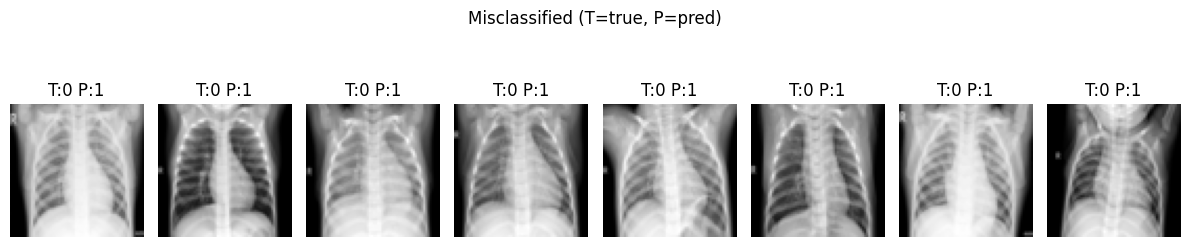

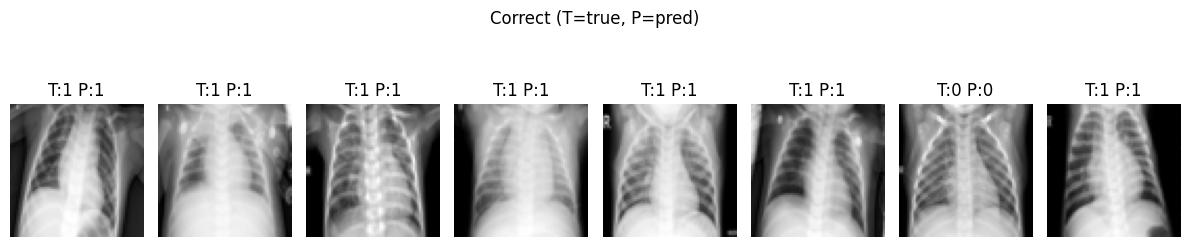

In [38]:
# Optional: Show examples of correct and incorrect predictions
# This helps understand where the model struggles

# TODO: Get predictions and find misclassified images
# Show side-by-side: correct predictions vs wrong predictions

# Your exploration code here (optional):
model.eval()

misclassified = []
correct = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        preds = outputs.argmax(dim=1)

        for i in range(images.size(0)):
            img = images[i].cpu()
            y_true = labels[i].item()
            y_pred = preds[i].item()

            if y_true != y_pred and len(misclassified) < 8:
                misclassified.append((img, y_true, y_pred))
            elif y_true == y_pred and len(correct) < 8:
                correct.append((img, y_true, y_pred))

        if len(misclassified) >= 8 and len(correct) >= 8:
            break


def show_examples(examples, title):
    n = len(examples)
    plt.figure(figsize=(12, 3))
    plt.suptitle(title)

    for idx, (img, y_true, y_pred) in enumerate(examples, start=1):
        plt.subplot(1, n, idx)

        img_np = img.permute(1, 2, 0).numpy() # i used AI to help me with this loop

        plt.imshow(img_np, cmap="gray" if img_np.shape[2] == 1 else None)
        plt.axis("off")
        plt.title(f"T:{y_true} P:{y_pred}")

    plt.tight_layout()
    plt.show()


show_examples(misclassified, "Misclassified (T=true, P=pred)")
show_examples(correct, "Correct (T=true, P=pred)")

---

## 🎓 Lab 3 Summary

### What We Accomplished:

✅ **Applied Lab 2 knowledge** to a new domain (images!)  
✅ **Loaded and visualized** medical images  
✅ **Built an MLP** for image classification  
✅ **Trained and evaluated** with medical metrics  
✅ **Discovered limitations** of MLPs for images  

### Key Insights:

1. **Flattening loses spatial information** - crucial for images!
2. **More features ≠ better performance** - if architecture is wrong
3. **Images are different from tabular data** - need different approaches
4. **Medical imaging is challenging** - but solvable with right tools!

### Coming Up:

- **Next week:** DICOM protocol, medical imaging modalities
- **Soon:** Better architectures for images (hint: CNNs!)
- **2-3 weeks:** Hospital visit to see MRI/CT machines!

---

## 📤 Submission Instructions

1. **Complete all TODOs** in this notebook
2. **Answer reflection questions** thoughtfully
3. **Save:** File → Download → .ipynb
4. **Name:** `Lab3_LastName1_LastName2.ipynb`
5. **Submit to Blackboard** by [deadline]

**Questions to discuss next class!** 💭

---